In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
data_path = '/content/drive/MyDrive/ISIC_image_data'

def load_data(data_dir):
    images = []
    labels = []
    for label, folder in enumerate(["Benign", "Malignant"]):
        path = os.path.join(data_dir, folder)
        for file in os.listdir(path):
            if file.endswith(".jpg"):
                img = cv2.imread(os.path.join(path, file))
                img = cv2.resize(img, (224, 224))
                img = img.astype(np.float32) / 255.0
                img = np.power(img, 2.0)
                img = (img * 255).astype(np.uint8) # Step 2: Polynomial Transformation x²
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
X_train, y_train = load_data(os.path.join(data_path, "Train"))
X_val, y_val = load_data(os.path.join(data_path, "Val"))

In [5]:
# ImageNet-style normalization
from tensorflow.keras.applications.resnet50 import preprocess_input
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

# One-hot encoding
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, 2)
y_val_cat = to_categorical(y_val, 2)

In [6]:
# Defining and Training ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(2)}

# Fine-tune the last 30 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=15, width_shift_range=0.1, height_shift_range=0.1)
train_generator = datagen.flow(X_train, y_train_cat, batch_size=32)

# Train
model.fit(train_generator, epochs=7, validation_data=(X_val, y_val_cat), class_weight=class_weights)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 133s 838ms/step - accuracy: 0.7507 - loss: 0.5086 - val_accuracy: 0.8027 - val_loss: 0.4437
Epoch 2/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 491ms/step - accuracy: 0.9071 - loss: 0.2257 - val_accuracy: 0.7455 - val_loss: 0.6574
Epoch 3/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 44s 504ms/step - accuracy: 0.9267 - loss: 0.1722 - val_accuracy: 0.8464 - val_loss: 0.4301
Epoch 4/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 493ms/step - accuracy: 0.9486 - loss: 0.1269 - val_accuracy: 0.8404 - val_loss: 0.4819
Epoch 5/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 497ms/step - accuracy: 0.9634 - loss: 0.0882 - val_accuracy: 0.8599 - val_loss: 0.6400
Epoch 6/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 44s 499ms/step - accuracy: 0.9798 - loss: 0.0690 - val_accuracy: 0.8524 - val_loss: 0.5105
Epoch 7/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 44s 500ms/step - accuracy: 0.9582 - loss: 0.1010 - val_accuracy: 0.8630 - val_loss: 0.4659


In [7]:
# Evaluation
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_val, y_pred_classes, target_names=["Benign", "Malignant"]))

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 267ms/step

Classification Report:
              precision    recall  f1-score   support

      Benign       0.88      0.85      0.86       339
   Malignant       0.85      0.88      0.86       325

    accuracy                           0.86       664
   macro avg       0.86      0.86      0.86       664
weighted avg       0.86      0.86      0.86       664



In [8]:
acc = accuracy_score(y_val, y_pred_classes)
print(f"\nValidation Accuracy: {acc:.4f}")


Validation Accuracy: 0.8630


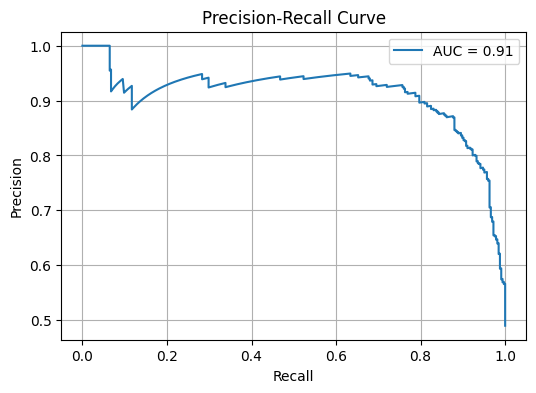

In [9]:
# PR Curve
precision, recall, _ = precision_recall_curve(y_val, y_pred[:, 1])
pr_auc = auc(recall, precision)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Predict single uploaded image
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()
for fn in uploaded.keys():
    img = image.load_img(fn, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.power(img_array, 2)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    class_names = ["Benign", "Malignant"]
    print(f"Prediction: {class_names[np.argmax(pred)]} (Confidence: {np.max(pred)*100:.2f}%)")